In [1]:
from arcgis.gis import GIS
from arcgis.mapping import WebMap

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Cloning

Well well well, if it isn't cloning, one of the most commonly asked things about in our API. Cloning items is pretty neat- it allows you to copy your content from one GIS organization to another, complete with dependent data items and all. Cloning has a ton of relevant uses, such as moving content from staging to production, creating backups, migrating your content to a new organization, and duplicating Web Maps used in Dev Summit demos. 

Web Maps give us a perfect example of how `clone_items()` works, due to the presence of various data sources within a single map. We'll take a look at the structure of the Web Maps, and what's retained versus what's changed when an item is cloned to a new GIS. Additionally, we'll look at what happens with the data sources contained in that Web Map, and how the function behaves differently depending on the presence of content in a target GIS.

Firstly, for reference on the function, full doc can be found here: https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#contentmanager


### Location and syntax

`clone_items()` is found under a GIS's `ContentManager` module. However, there are a couple caveats to this. Firstly, the `ContentManager` is rarely invoked by name; instead, it's usually called via `gis.content`. Furthermore, this isn't a function you call on the GIS you're accessing your data in- you have to call it from the GIS object of the organization you're hoping to clone into.

So, the workflow goes something along the lines of:

- instantiate your source GIS
- find the portal items you want to clone
    - make an `Item` instance out of each portal item, and add them to a list
- instantiate your target GIS
- call `clone_items()` with your target GIS, but pass in the list of items from your source GIS
- profit wildly
    
It's not a particularly long workflow, but it's a super helpful one to remember. We'll begin, and take note of important stuff we find along the way.

In [2]:
# first, define your source GIS. you can also define your target now if you want, it doesn't really matter.
gis = GIS(profile="your_online_profile")

<Item title:"I'm a map, clone me! Or don't." type:Web Map owner:nparavicini_geosaurus>
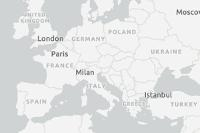

In [3]:
# let's go ahead and grab a couple items from our portal- a webmap and a feature layer
webmap = gis.content.get("354a9f90920f454ca83aa8fbfbc7adfa")
webmap

In [4]:
WebMap(webmap).layers

[{
   "id": "186c77a0435-layer-2",
   "title": "CA OR Airports - ad363a",
   "url": "https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ad363a/FeatureServer/0",
   "itemId": "f1e3ea6b9b8f43f595ec2f4f88113069",
   "layerType": "ArcGISFeatureLayer",
   "popupInfo": {
     "popupElements": [
       {
         "type": "fields"
       },
       {
         "type": "attachments",
         "displayType": "auto"
       }
     ],
     "showAttachments": true,
     "fieldInfos": [
       {
         "fieldName": "FID",
         "label": "FID",
         "visible": false
       },
       {
         "fieldName": "AIRPORT",
         "isEditable": true,
         "label": "AIRPORT",
         "visible": true
       },
       {
         "fieldName": "CITY",
         "isEditable": true,
         "label": "CITY",
         "visible": true
       },
       {
         "fieldName": "COUNTRY",
         "isEditable": true,
         "label": "COUNTRY",
         "visible": true
       },
       {
  

<Item title:"CA/OR Airports" type:Feature Layer Collection owner:nparavicini_geosaurus>
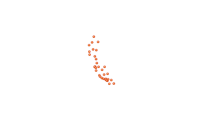

In [5]:
flayer = gis.content.get("f1e3ea6b9b8f43f595ec2f4f88113069")
flayer

In [6]:
# now, we'll define our target GIS
target = GIS(profile="np_pypi")

In [7]:
# finally, the big step. in it's most basic form, all it needs is a list of items to clone
# make sure to call on it on target
cloned_item_list = target.content.clone_items([webmap], search_existing_items = False)

In [8]:
cloned_item_list

[<Item title:"CA/OR Airports" type:Feature Layer Collection owner:nparavicini_pythonapi>,
 <Item title:"Light Gray Canvas Base" type:Vector Tile Layer owner:nparavicini_pythonapi>,
 <Item title:"Light Gray Canvas Reference" type:Vector Tile Layer owner:nparavicini_pythonapi>,
 <Item title:"I'm a map, clone me! Or don't." type:Web Map owner:nparavicini_pythonapi>]

We now have a list of items that exist in the target organization. Notice how it also includes the data sources for the Web Map, so the new cloned item doesn't have to reference the items from the other organization. Let's compare the layers of the source vs. target webmap.

<Item title:"I'm a map, clone me! Or don't." type:Web Map owner:nparavicini_pythonapi>
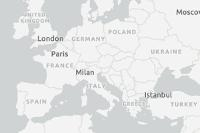

In [9]:
cloned_map = cloned_item_list[3]
cloned_map

In [10]:
WebMap(cloned_map).layers[0]

{
  "id": "186c77a0435-layer-2",
  "title": "CA OR Airports - ad363a",
  "url": "https://services8.arcgis.com/SZN16RkUszkfOcmq/arcgis/rest/services/ad363a/FeatureServer/0",
  "itemId": "e80f9996bf7b4c5e9ae2129fe3aaa17c",
  "layerType": "ArcGISFeatureLayer",
  "popupInfo": {
    "popupElements": [
      {
        "type": "fields"
      },
      {
        "type": "attachments",
        "displayType": "auto"
      }
    ],
    "showAttachments": true,
    "fieldInfos": [
      {
        "fieldName": "FID",
        "label": "FID",
        "visible": false
      },
      {
        "fieldName": "AIRPORT",
        "isEditable": true,
        "label": "AIRPORT",
        "visible": true
      },
      {
        "fieldName": "CITY",
        "isEditable": true,
        "label": "CITY",
        "visible": true
      },
      {
        "fieldName": "COUNTRY",
        "isEditable": true,
        "label": "COUNTRY",
        "visible": true
      },
      {
        "fieldName": "IATA",
        "isEdit

As we can see, it automatically remaps to the items that were created, which is awesome. But what happens if those items already exist in the new portal? Will that affect anything? Let's delete our cloned Web Map (but not the other newly cloned items) and try running it again.

In [11]:
cloned_map.delete()

True

In [12]:
new_clones = target.content.clone_items([webmap])

In [13]:
new_clones

[<Item title:"I'm a map, clone me! Or don't." type:Web Map owner:nparavicini_pythonapi>]

In [14]:
cloned_map = new_clones[0]

<Item title:"I'm a map, clone me! Or don't." type:Web Map owner:nparavicini_pythonapi>
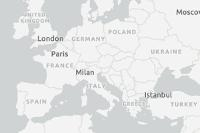

In [15]:
cloned_map

In [16]:
WebMap(cloned_map).layers[0]

{
  "id": "186c77a0435-layer-2",
  "title": "CA OR Airports - ad363a",
  "url": "https://services8.arcgis.com/SZN16RkUszkfOcmq/arcgis/rest/services/ad363a/FeatureServer/0",
  "itemId": "e80f9996bf7b4c5e9ae2129fe3aaa17c",
  "layerType": "ArcGISFeatureLayer",
  "popupInfo": {
    "popupElements": [
      {
        "type": "fields"
      },
      {
        "type": "attachments",
        "displayType": "auto"
      }
    ],
    "showAttachments": true,
    "fieldInfos": [
      {
        "fieldName": "FID",
        "label": "FID",
        "visible": false
      },
      {
        "fieldName": "AIRPORT",
        "isEditable": true,
        "label": "AIRPORT",
        "visible": true
      },
      {
        "fieldName": "CITY",
        "isEditable": true,
        "label": "CITY",
        "visible": true
      },
      {
        "fieldName": "COUNTRY",
        "isEditable": true,
        "label": "COUNTRY",
        "visible": true
      },
      {
        "fieldName": "IATA",
        "isEdit

Boom. Amazing. As we can see, every different situation we tried, it got cloned and remapped properly. 